In [138]:
# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# Type hints
from typing import Callable, Union, Tuple

import os
# Add your custom path
import sys
sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate
from GEMS_TCO import load_data

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd

import matplotlib.transforms as transforms

from pathlib import Path
import json
from json import JSONEncoder

# Summary

We will explore data on an hourly scale. ```The cyclic pattern``` shown in the ```semivariograms``` indicates that we should fit the data with a model that can explain this cyclic pattern.

Secondly, ```asymmetric cross-variograms``` on some days imply that there is ```space and time interaction```, hence we should consider a non-separable model.

Lastly, ```latitude-sliced``` data shows ```spatial non-stationarity```. I plan to ```detrend for 5x10 spatial points``` in the N5N10 E110E120 region.

## Quick load empirical semiovariograms from Amarel

In [2]:
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/GEMS_TCO_EDA/outputs"
input_filename = "empirical_n135_45_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    d135_45_20000= pickle.load(pickle_file)


input_filename = "empirical_n45_135_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    dn45_n135_20000= pickle.load(pickle_file)


input_filename = "empirical_lat_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    d_lat_20000= pickle.load(pickle_file)


input_filename = "empirical_lon_sem_20000_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    d_lon_20000= pickle.load(pickle_file)



# load estimates

In [77]:
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"


input_filename = "vecc_inter_estimates_5000_july24.pkl"

input_filename = "full_estimation_1250_july24.pkl"
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    amarel_map1250 = pickle.load(pickle_file)

# Assuming df_1250 is your DataFrame
df_1250 = pd.DataFrame()
for key in amarel_map1250:
    tmp = pd.DataFrame(amarel_map1250[key][0].reshape(1, -1), columns=['sigmasq', 'range_lat', 'range_lon', 'advec_lat', 'advec_lon', 'beta', 'nugget'])
    tmp['loss'] = amarel_map1250[key][1]
    df_1250 = pd.concat((df_1250, tmp), axis=0)

# Generate date range
date_range = pd.date_range(start='07-01-24', end='07-31-24')

# Ensure the number of dates matches the number of rows in df_1250
if len(date_range) == len(df_1250):
    df_1250.index = date_range
else:
    print("The number of dates does not match the number of rows in the DataFrame.")



df_1250.head(15)

,sigmasq,range_lat,range_lon,advec_lat,advec_lon,beta,nugget,loss
2024-07-01,24.793444,1.584529,1.718248,0.009089,-0.107299,0.131038,2.717239,14068.529297
2024-07-02,24.424301,1.997055,1.942683,0.043588,-0.072679,0.137124,1.513148,12357.715820
2024-07-03,26.009497,1.215236,1.558868,0.023392,-0.150548,0.199850,2.890678,14948.140625
2024-07-04,24.701347,1.612308,1.822960,-0.164069,-0.237443,0.131595,3.636499,14786.204102
2024-07-05,22.598671,2.901185,3.722327,-0.011729,-0.152072,0.072866,2.397249,12096.261719
2024-07-06,25.594908,1.702692,2.255174,0.017462,-0.158125,0.098684,3.850205,14690.248047
2024-07-07,26.030510,1.261084,2.831952,0.054831,-0.343255,0.103045,4.596346,15342.459961
2024-07-08,26.043682,0.995279,1.629503,-0.019824,-0.411626,0.164296,2.751402,14857.195312
2024-07-09,24.052071,1.377774,2.357721,0.021439,-0.220316,0.142847,1.675457,12666.991211
2024-07-10,25.766109,1.392051,2.358171,0.026684,-0.077366,0.150648,3.821218,14987.769531


# Empirical and theoretical directional semivariograms

# smooth 0.5

In [107]:

# day13_1250_estimates: [23.36, 2.72, 3.92, -0.143, 0.0945, 0.095, 1.995, 11476.89]
df_1250.iloc[12] = np.array([24.793, 2.3845, 2.718, 0.0090, -0.107299, 0.131, 3.11, 14000 ])
# day1 1250_estimates: 24.793, 1.5845, 1.718, 0.0090, -0.107299, 0.131, 2.71, 14000
df_1250.iloc[0] = np.array([24.793, 2.3845, 2.718, 0.0090, -0.107299, 0.131, 3.11, 14000 ])
# df_1250.iloc[3] = np.array([24.70, 2.6123, 2.822, -0.164, -0.237, 0.1315, 2.6364, 14786])
df_1250.iloc[17] = np.array( [23.32, 2.295, 4.319, -0.079, -0.109, 0.1314, 2.7379, 14786] ) 

        sigma  range_lat  range_lon  advec_lat  advec_lon      beta    nugget  \
12  23.661254   2.048036   3.493290  -0.129581   0.073617  0.136803  1.367449   
0   25.764724   1.650104   1.800703   0.008788  -0.108062  0.125944  2.735307   
3   24.734497   1.631283   1.847290  -0.151081  -0.210950  0.111696  3.756732   
17  24.210509   1.379735   3.617639  -0.078720  -0.109096  0.122883  2.776996   

            loss  
12  11313.768120  
0   14067.368875  
3   14772.307547  
17  13416.184966  


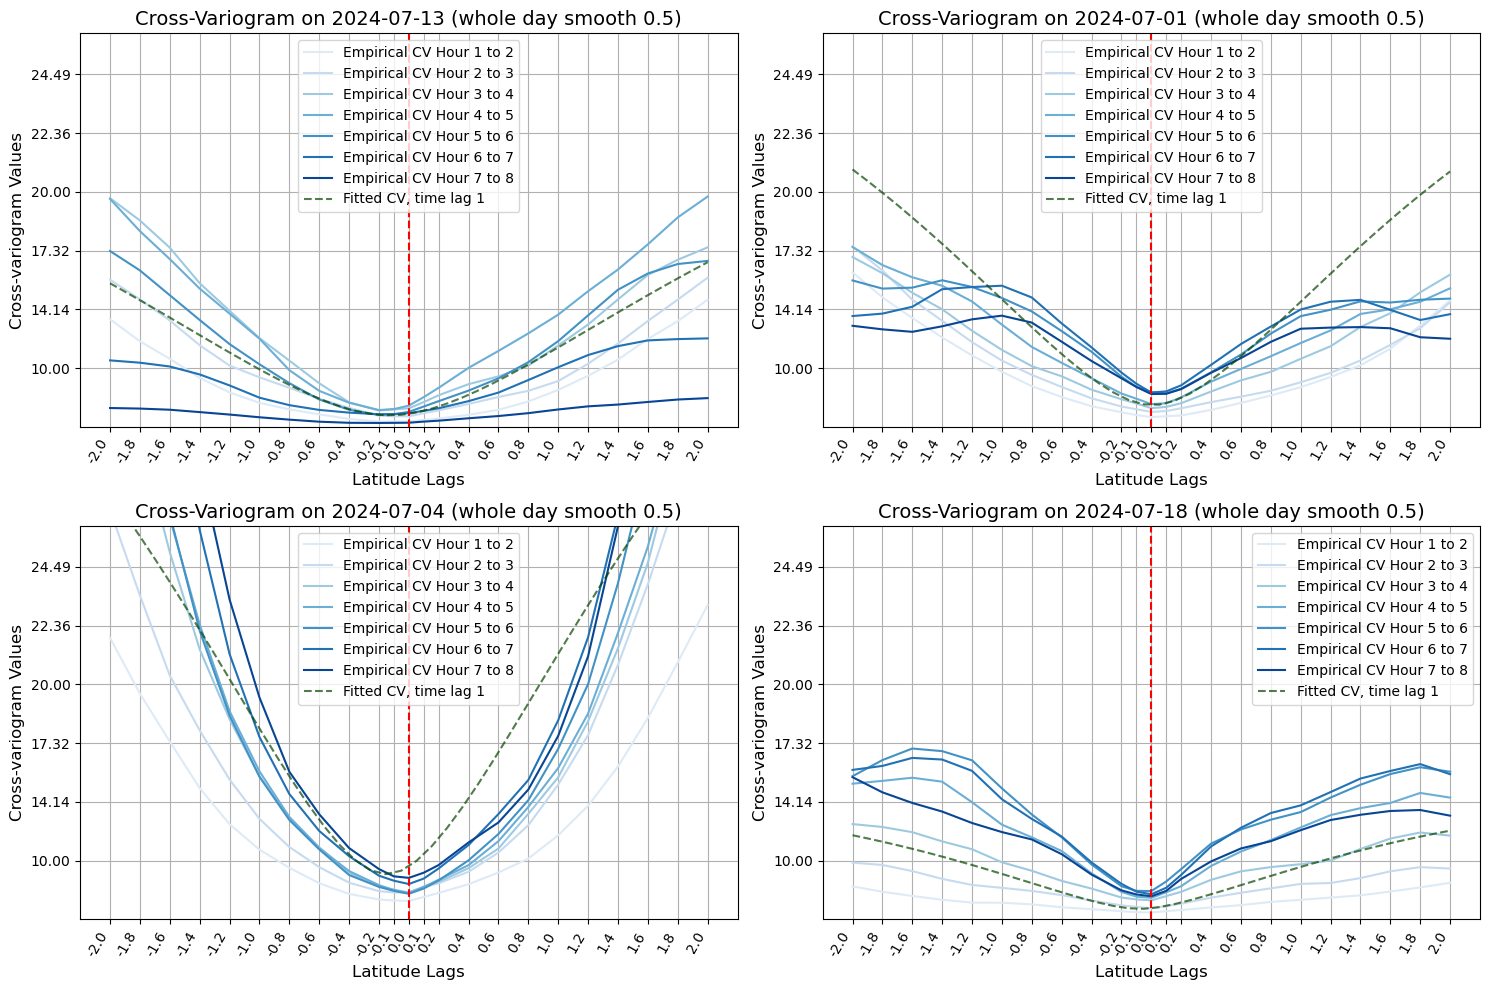

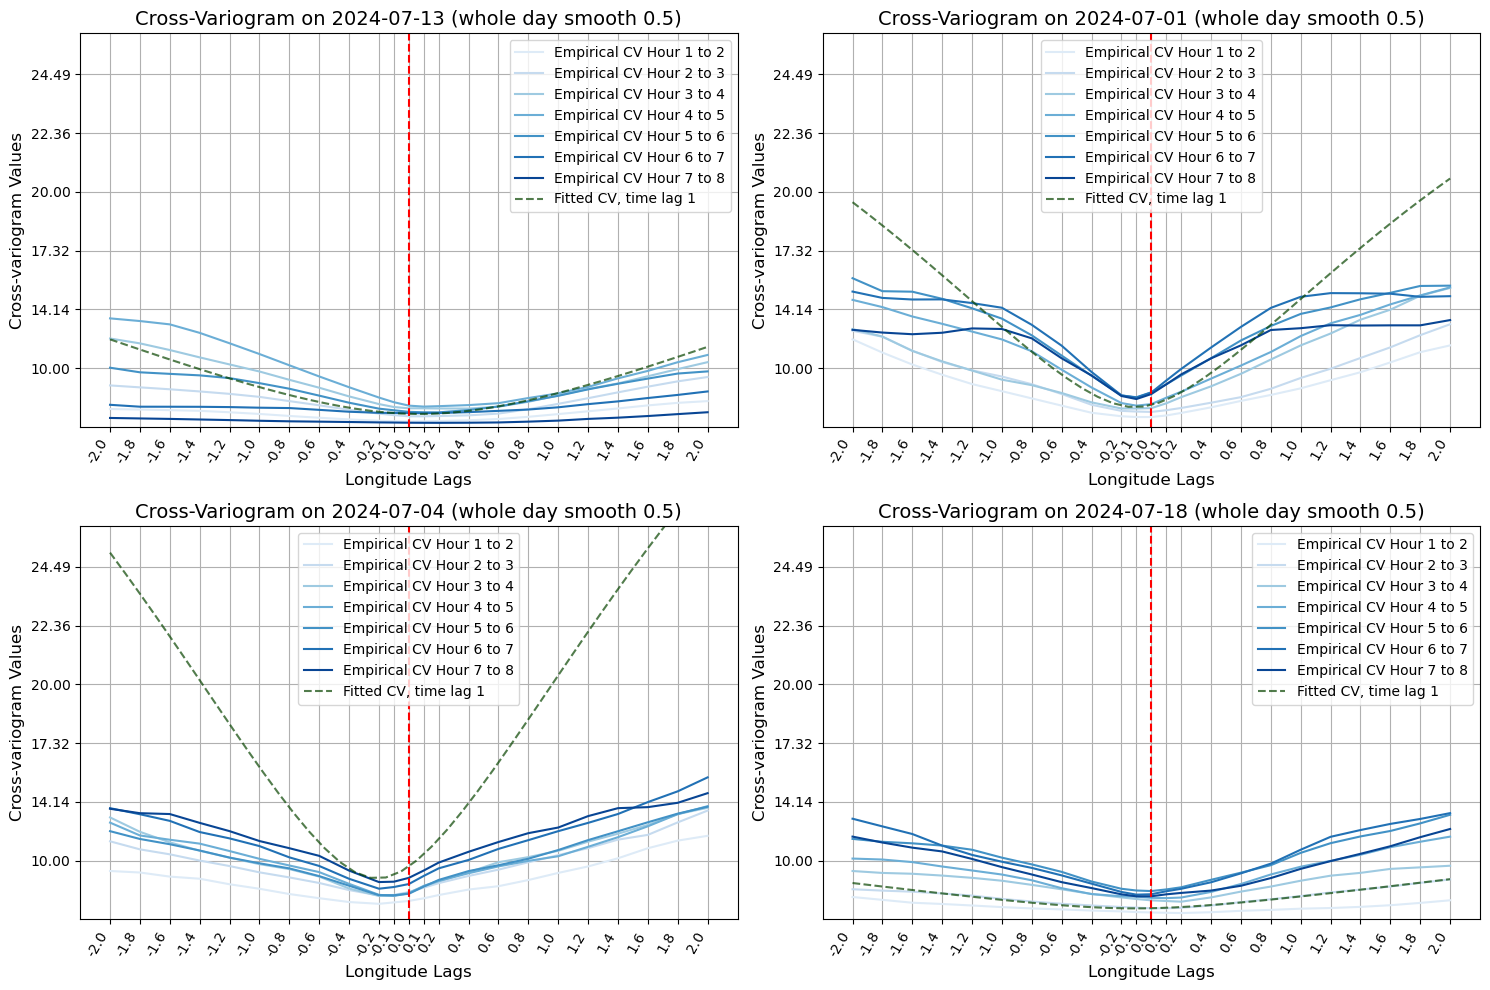

In [222]:
# save_path = "C:\\Users\\joonw\\tco\\GEMS_TCO-2\\plots\\directional_semivariograms\\tmp_save" # window
save_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/plots/directional_semivariograms/tmp_save"
length_of_analysis = 'whole day smooth 0.5'
smooth = 0.5
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)


input_filename = "full_day_v05_1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v05 = pd.read_csv(input_filepath)
df_full_v05 = df_full_v05.iloc[:,5:13]

print(df_full_v05.iloc[[12,0,3,17],:])

# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
x_values = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

df_full_v05.iloc[12] = np.array( [23.6612, 2.0480, 3.4932, -0.1295, 0.073617, 0.1368 ,1.3674, 500 ]  )
df_full_v05.iloc[3] = np.array( [34, 1.6312, 1.8472, -0.151, -0.2109, 0.1116, 3.756, 500 ]  )
df_full_v05.iloc[17] = np.array( [ 12.2105, 1.3797, 3.6176, -0.0782, -0.1090, 0.1228, 2.77,500 ]  )
dayss = [[13,1,4,18]]

for days in dayss:

    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    deltas = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days,deltas, df_full_v05, instance_sem.theoretical_gammma_kv)

    # longitude direction
    deltas = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,deltas, df_full_v05, instance_sem.theoretical_gammma_kv)



# smooth 1.0

       sigma  range_lat  range_lon  advec_lat  advec_lon      beta    nugget  \
0  25.457116    2.37404   2.407446   0.119997   0.000001  0.000004  3.712378   
1  24.997861    2.82043   2.798389   0.100012   0.099996 -0.000002  2.479622   

           loss  
0  18427.647821  
1  17718.004433  


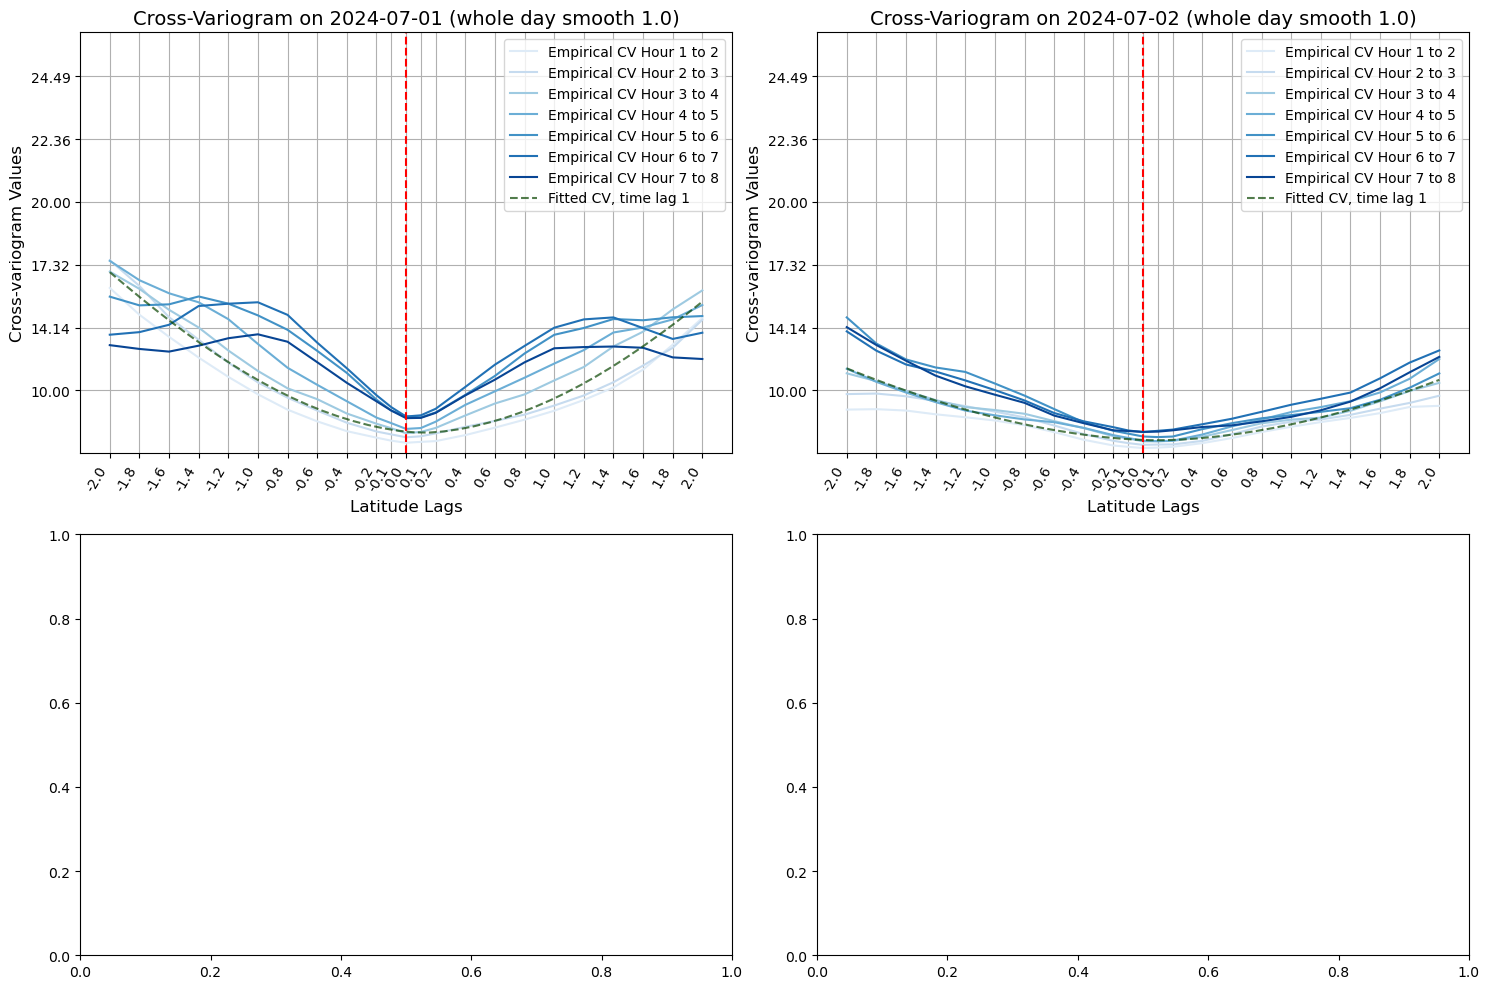

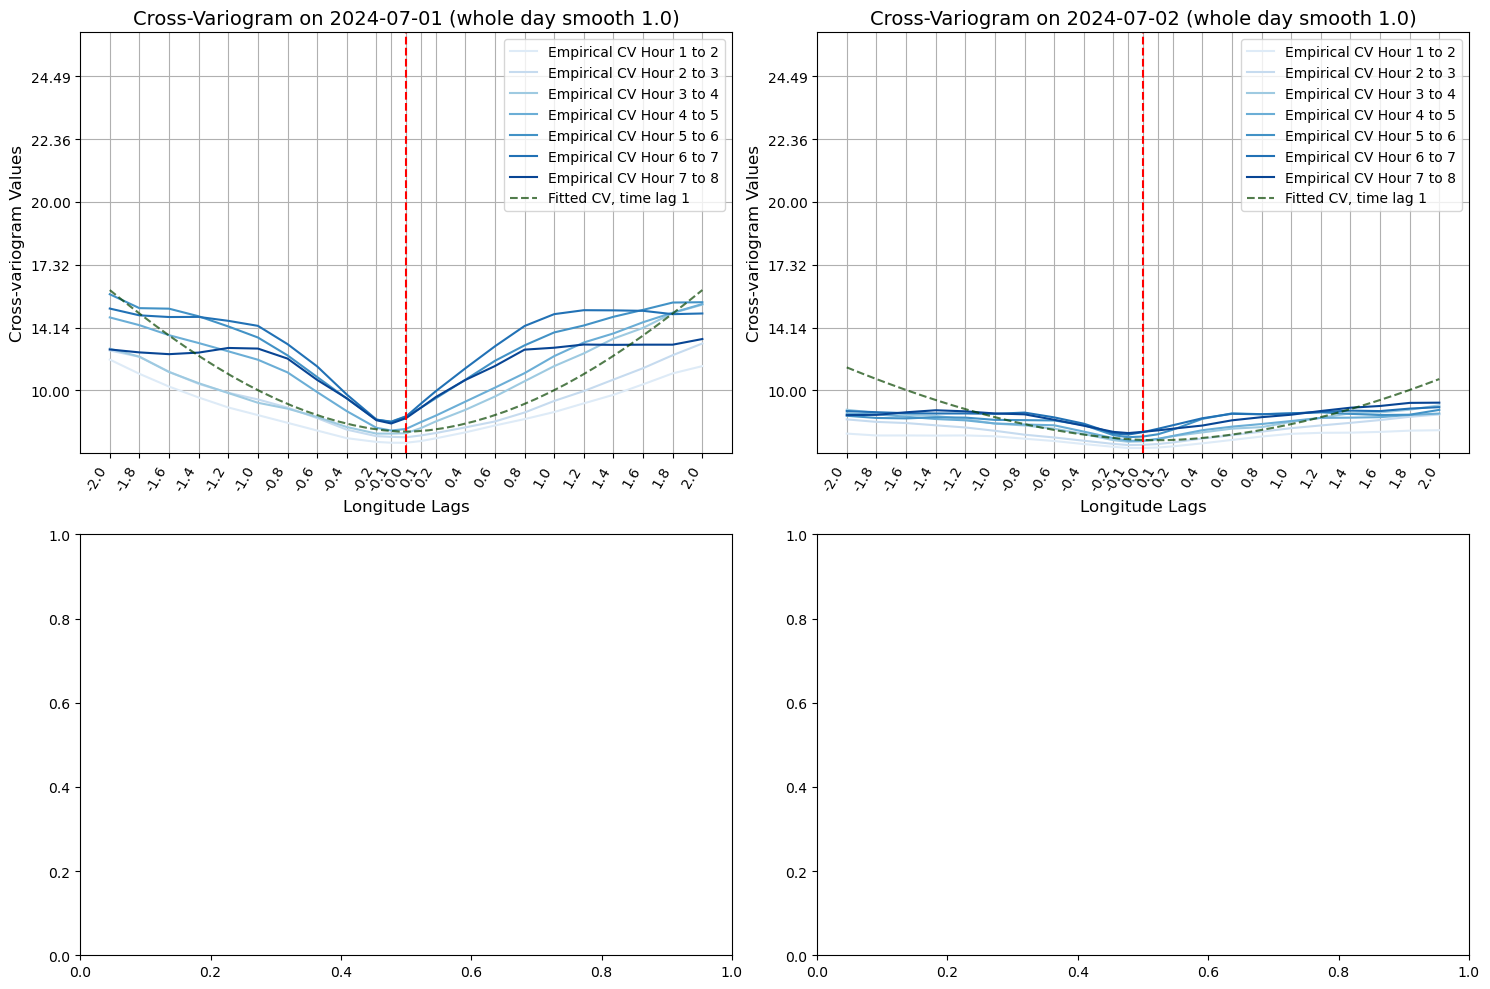

In [27]:
# save_path = "C:\\Users\\joonw\\tco\\GEMS_TCO-2\\plots\\directional_semivariograms\\tmp_save" # window
save_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/plots/directional_semivariograms/tmp_save"
length_of_analysis = 'whole day smooth 1.0'
smooth = 1.0
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_day_v10_1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v10 = pd.read_csv(input_filepath)
df_full_v10 = df_full_v10.iloc[:,5:13]


print(df_full_v10.head())
df_full_v10.iloc[0] = np.array( [32, 2.37404 ,  2.407446,   0.119997 ,  0.000001 , 0.000004 , 5.712378 , 4000] )

df_full_v10.iloc[1] = [24.997861,  2.82043, 2.798389,  0.100012, 0.099996, -0.000002 , 4.479622 ,400]


# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
x_values = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

dayss = [[1,2]]

for days in dayss:

    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    deltas = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days,deltas, df_full_v10, instance_sem.theoretical_gammma_kv)

    # longitude direction
    deltas = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,deltas, df_full_v10, instance_sem.theoretical_gammma_kv)



# smooth 1.5 

# empirical semivariogram and variances

In [ ]:
keys = analysis_data_map.keys()


In [225]:
day = 1
hour = 1
days = [13,1,4,18]
for day in days:
    lat_lon_resolution = [5,5]
    mm_cond_number = 20


    # input_path = Path("C:\\Users\\joonw\\tco\\Extracted_data")  # window
    input_path = Path("/Users/joonwonlee/Documents/GEMS_DATA")
    instance = load_data(input_path)

    years = ['2024']
    month_range =[7,8]
    idx_for_datamap= [ 8*(day-1),8*day]


    map, ord_mm, nns_map= instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)
    analysis_data_map, aggregated_data = instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap= idx_for_datamap)

    keys = list(analysis_data_map.keys())

    print(f' The variance of ozone on day {day}, hour {hour+1}: {torch.var(analysis_data_map[keys[hour]][:,2])}')
    print(f' The averaged variance of ozone on day {day}, : {torch.var(aggregated_data[:,2])}')

    print(f'Sorted semivariograms on day {day}, hour {hour+1} : {sorted(d_lon_20000[day][hour])}')

 The variance of ozone on day 13, hour 2: 13.33938148460747
 The averaged variance of ozone on day 13, : 14.62403308317626
Sorted semivariograms on day 13, hour 2 : [4.235230916167573, 4.237341678277988, 4.2926009001241034, 4.419596986227949, 4.467445523761056, 4.748888830786126, 4.752814190214053, 5.386875472781023, 5.472734715960162, 6.056490218252279, 6.256651365193291, 6.618774509586274, 6.983736400645132, 7.143483725946311, 7.4924043987425, 7.66289556902348, 7.762676856239728, 7.996375950332828, 8.199415543232554, 8.269781630954324, 8.39669630937684, 8.799179123499531, 9.21152921330578]
 The variance of ozone on day 1, hour 2: 19.45832184612966
 The averaged variance of ozone on day 1, : 19.757172730627634
Sorted semivariograms on day 1, hour 2 : [5.037558111583636, 5.105801885167866, 5.211153982425005, 5.319972489570348, 5.666227978056196, 6.126883370798905, 6.410439931141244, 7.1112376336651595, 7.474432259884309, 8.051090051202355, 8.520709190415706, 9.122888295416375, 9.253537

        sigma  range_lat  range_lon  advec_lat  advec_lon      beta    nugget  \
12  26.998319   0.469808   0.814998  -0.126384   0.062735  0.599311  2.364632   
0   27.345010   0.492045   0.530069   0.004869  -0.115571  0.428724  4.472029   
3   20.310771   0.433088   0.453008  -0.157179  -0.213335  0.422450  5.319031   
17  20.577795   0.294381   0.799645  -0.076792  -0.107273  0.564021  3.858429   

            loss  
12  11473.860510  
0   14171.085058  
3   14842.652225  
17  13521.662949  


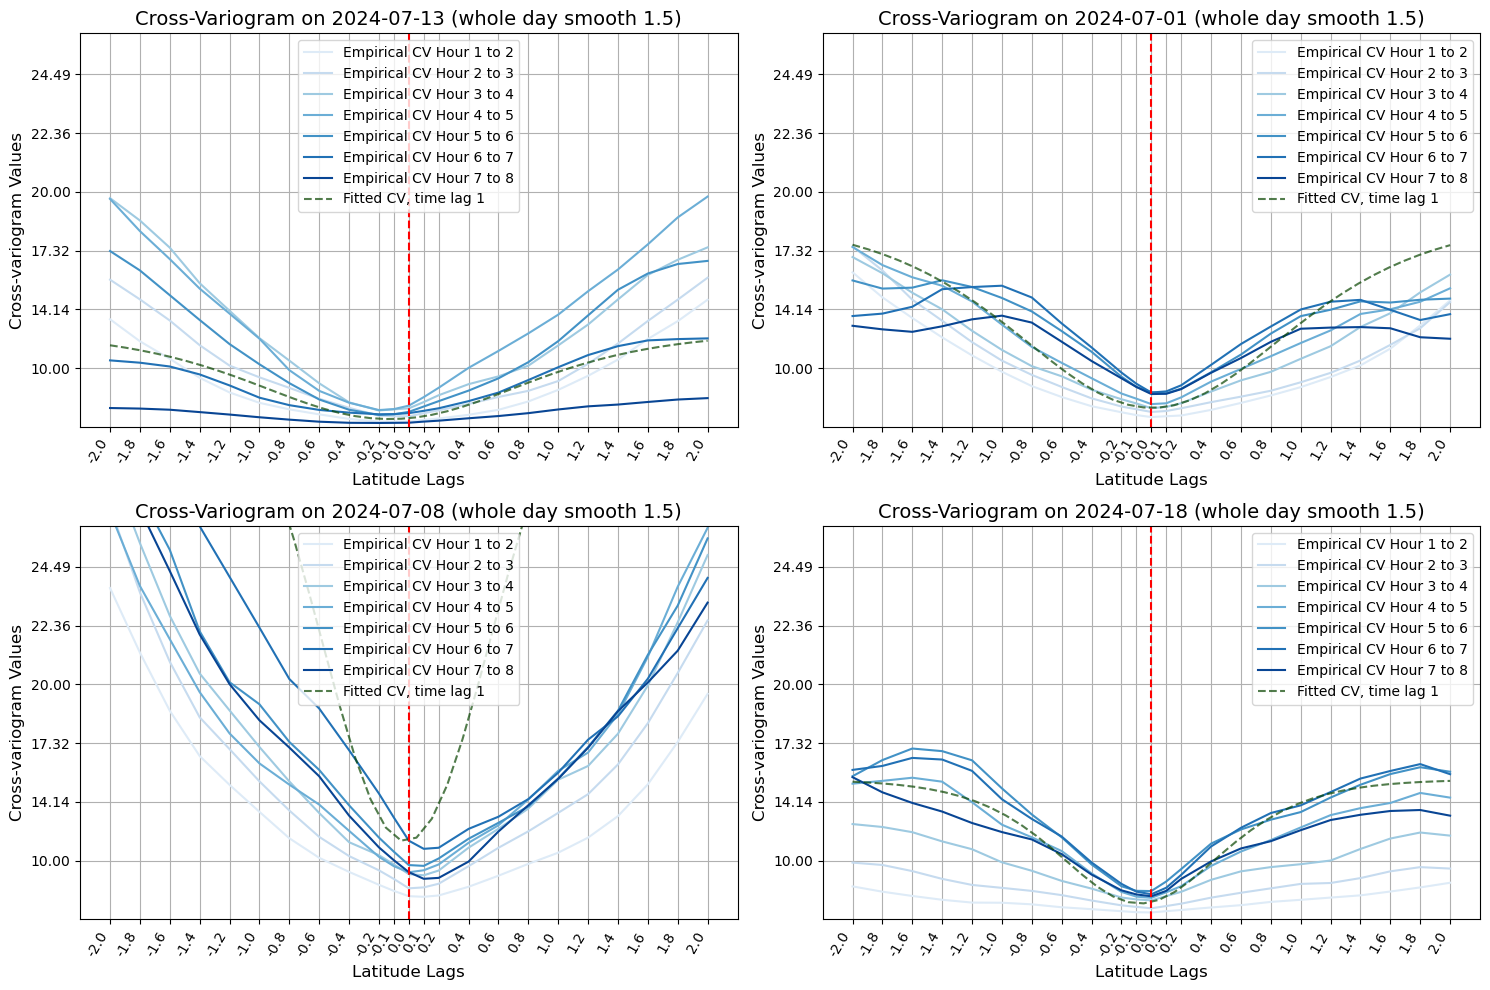

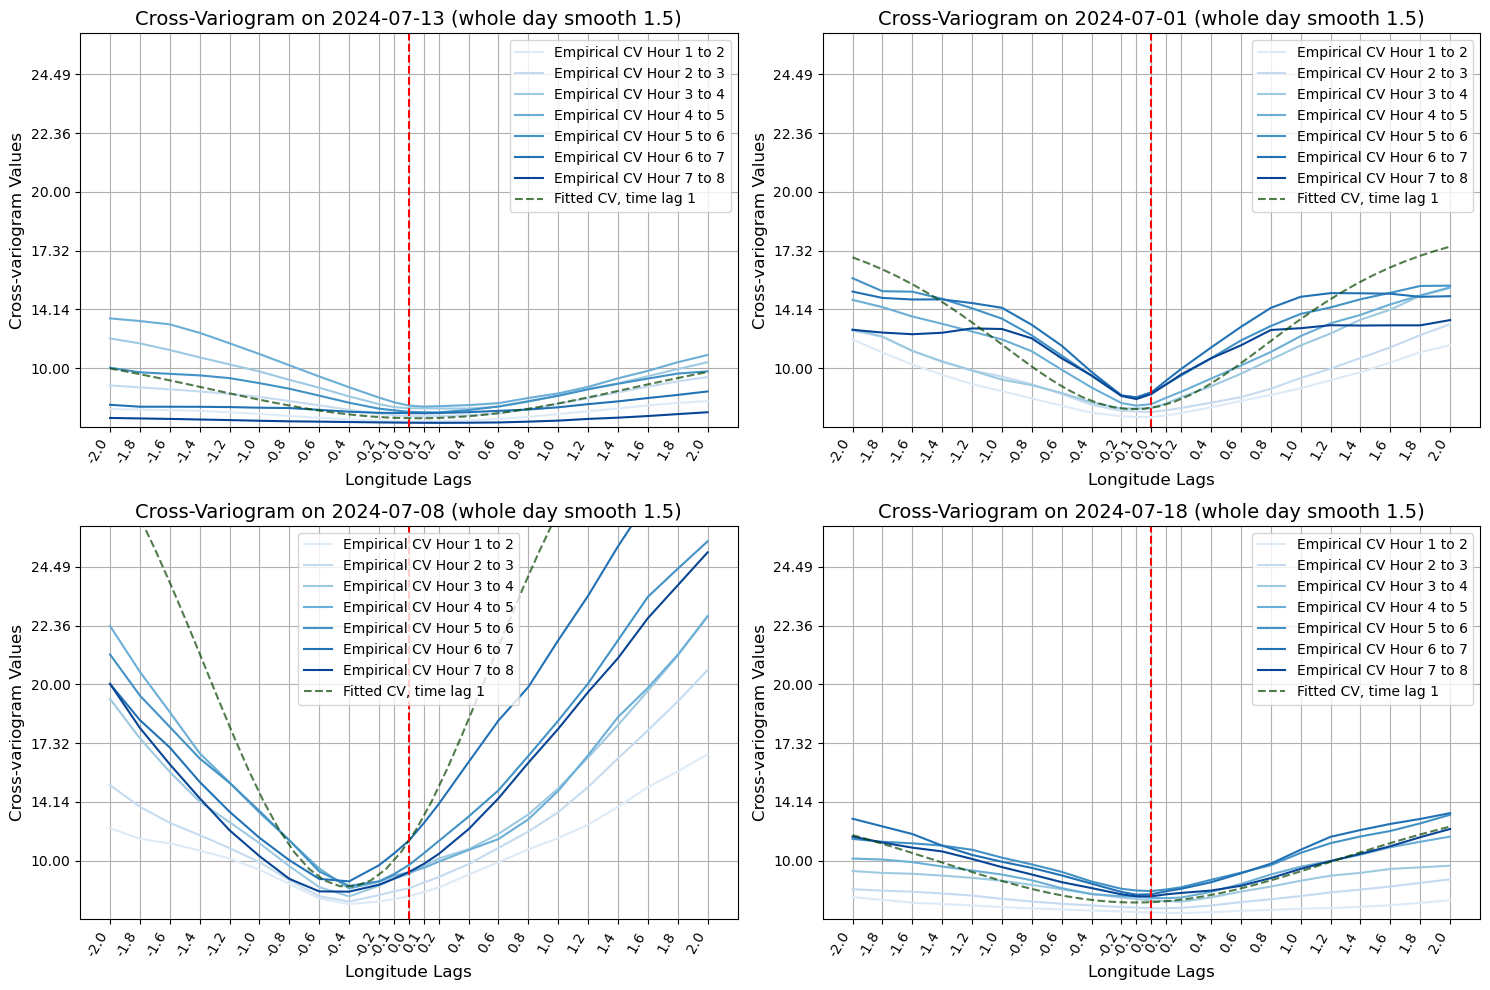

In [ ]:
# save_path = "C:\\Users\\joonw\\tco\\GEMS_TCO-2\\plots\\directional_semivariograms\\tmp_save" # window
save_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/plots/directional_semivariograms/tmp_save"
length_of_analysis = 'whole day smooth 1.5'
smooth = 1.5
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_v15_1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v15 = pd.read_csv(input_filepath)
df_full_v15 = df_full_v15.iloc[:,5:13]

print(df_full_v15.iloc[[12,0,3,17],:])


df_full_v15.iloc[12] = np.array( [10.3450, 0.4698,0.8149, -0.12638, 0.062735, 0.599311, 2.3620 ,500 ]  )
df_full_v15.iloc[3] = np.array( [ 32, 0.43308, 0.453, -0.1571, -0.2133, 0.4224, 5.319, 500 ]  )
df_full_v15.iloc[0] = np.array( [ 14.345, 0.492, 0.530069, 0.004869, -0.1155, 0.4287, 4.4720, 500 ]  )
df_full_v15.iloc[17] = np.array( [ 11.577, 0.2943, 0.7996, -0.0767, -0.1072, 0.5640, 3.8548, 500 ]  )
# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
x_values = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

dayss = [[13,1,4,18]]

for days in dayss:

    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    deltas = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days,deltas, df_full_v15, instance_sem.theoretical_gammma_kv)

    # longitude direction
    deltas = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,deltas, df_full_v15, instance_sem.theoretical_gammma_kv)


# Old scatter plots for empirical semivariograms

In [ ]:
instance_sem = evaluate.CrossVariogram()

# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
x_values = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))

for days in dayss:
    tolerance = 0.02
    d45 = np.arctan2(1,1)
    d135 = np.arctan2(-1,-1)  

    # y=x direction
    instance_sem.plot_directional_sem(x_values, d135_45_20000, days, d135, d45)

    # y=-x direction
    dn45 = np.arctan2(-1,1)
    dn135 = np.arctan2(1,-1)
    instance_sem.plot_directional_sem(x_values, dn45_n135_20000, days, dn45, dn135)

    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    deltas = [ ( round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_sem( d_lat_20000,days,deltas)

    # longitude direction
    deltas = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_sem( d_lon_20000,days,deltas)




### which hours are important?

In [ ]:
ssdf = d_lon_20000
res = [] 

for j in range(1, len(ssdf)):
    tmp = []
    sdf = d_lon_20000[j]
    for i in range(len(sdf)-1):
        # print(f'correlation between {i} and {i+1} in day {j} {np.corrcoef( sdf[i], sdf[i+1])}' )
        tmp.append( np.corrcoef( sdf[i], sdf[i+1])[0][1] )
    min_correlation_index = np.argmax(tmp)
    res.append(min_correlation_index)


plt.hist(res, bins=range(min(res), max(res) + 2), edgecolor='black', align='left')
plt.xlabel('Index of Maximum Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Index of Maximum Correlation')
plt.xticks(range(min(res), max(res) + 1))
plt.show()